## Deep Q-Networks

In [1]:
import tensorflow as tf
import numpy as np
import scipy.misc
import random
import gym
import os

from gridworld import gameEnv

tf.logging.set_verbosity(tf.logging.ERROR)

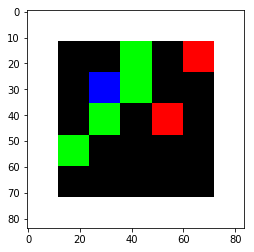

In [2]:
env = gameEnv(partial=False, size=5)

In [3]:
env.step

<bound method gameEnv.step of <gridworld.gameEnv object at 0x7f3d886ec3c8>>

### ***QNetwork***

In [3]:
class QNetwork() :
    def __init__(self, h_size) :
        self.scalarInput = tf.placeholder(shape=[None, 84*84*3], dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput, shape=[-1,84,84,3])
        
        self.conv1 = tf.contrib.layers.convolution2d(inputs=self.imageIn, num_outputs=32, kernel_size=[8,8], stride=[4,4], padding='VALID', biases_initializer=None)
        self.conv2 = tf.contrib.layers.convolution2d(inputs=self.conv1, num_outputs=64, kernel_size=[4,4], stride=[2,2], padding='VALID', biases_initializer=None)
        self.conv3 = tf.contrib.layers.convolution2d(inputs=self.conv2, num_outputs=64, kernel_size=[3,3], stride=[1,1], padding='VALID', biases_initializer=None)
        self.conv4 = tf.contrib.layers.convolution2d(inputs=self.conv3, num_outputs=h_size, kernel_size=[7,7], stride=[1,1], padding='VALID', biases_initializer=None)
        
        self.streamAC, self.streamVC = tf.split(self.conv4, 2, 3)
        self.streamA = tf.contrib.layers.flatten(self.streamAC)
        self.streamV = tf.contrib.layers.flatten(self.streamVC)
        
        self.AW = tf.Variable(tf.random_normal([h_size//2, env.actions]))
        self.VW = tf.Variable(tf.random_normal([h_size//2, 1]))
        
        self.Advantage = tf.matmul(self.streamA, self.AW)
        self.Value = tf.matmul(self.streamV, self.VW)
        
        self.QOut = self.Value + tf.subtract(self.Advantage, tf.reduce_mean(self.Advantage, axis=1, keep_dims=True))
        self.predict = tf.argmax(self.QOut, 1)
        
        self.targetQ = tf.placeholder(shape=[None], dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None], dtype=tf.int32)
        
        self.actions_onehot = tf.one_hot(self.actions, env.actions, dtype=tf.float32)
        self.Q = tf.reduce_sum(tf.multiply(self.QOut, self.actions_onehot), axis=1)
        
        self.td_error = tf.square(self.targetQ-self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate=1e-4)
        self.updateModel = self.trainer.minimize(self.loss)

### ***Experience replay***

In [4]:
class Experience_buffer() :
    def __init__(self, buffer_size=1000) :
        self.buffer = []
        self.buffer_size = buffer_size
        
    def add(self, experience) :
        if len(self.buffer)+len(experience) >= self.buffer_size :
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
            
        self.buffer.extend(experience)
        
    def sample(self, size) :
        return np.reshape(np.array(random.sample(self.buffer, size)), [size, 5])
    
def processState(states) :
    return np.reshape(states, [84*84*3])

def updateTargetGraph(tfVars, tau) :
    total_vars = len(tfVars)
    op_holder = []
    
    for idx, var in enumerate(tfVars[0:total_vars//2]) :
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau)+((1-tau)*tfVars[idx+total_vars//2].value())))
        
    return op_holder

def updateTarget(op_holder, sess) :
    for op in op_holder :
        sess.run(op)

### ***Training***

Hyper parameters

In [5]:
batch_size = 32
update_freq = 4
y = 0.99    # discounting factor
startE = 1
endE = 0.1
annealing_step = 1000.    # How many steps of training to reduce startE to endE
num_episodes = 1000
pre_train_steps = 1000
max_epLength = 50    # The max allowed length of episode
load_model = False
path = './dqn'
h_size = 512
tau = 1e-3    # Rate to update target newtork toward primary network

Training

In [6]:
tf.reset_default_graph()
mainQN = QNetwork(h_size)
targetQN = QNetwork(h_size)

init = tf.global_variables_initializer()
saver = tf.train.Saver()
trainable = tf.trainable_variables()
targetOps = updateTargetGraph(trainable, tau)
myBuffer = Experience_buffer()

e = startE
stepDrop = (startE-endE)/annealing_step    # decaying epsilon to endE

jList = []
rList = []
total_steps = 0

if not os.path.exists(path) :
    os.mkdir(path)
    
with tf.Session() as sess :
    if load_model :
        print('Loading...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess, ckpt.model_checkpoint_path)
        
    sess.run(init)
    updateTarget(targetOps, sess)
    
    for i in range(num_episodes) :
        episodeBuffer = Experience_buffer()
        
        s = env.reset()
        s = processState(s)
        d = False
        rAll = 0
        j = 0
        
        while j < max_epLength :
            j += 1
            
            if np.random.rand(1) < e or total_steps < pre_train_steps :
                a = np.random.randint(0, 4)
            else :
                a = sess.run(mainQN.predict, feed_dict={mainQN.scalarInput: [s]})[0]
                
            s1, r, d = env.step(a)
            s1 = processState(s1)
            total_steps += 1
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]), [1,5]))
            
            if total_steps > pre_train_steps :
                if e > endE :
                    e -= stepDrop
                    
                if total_steps % (update_freq) == 0 :
                    trainBatch = myBuffer.sample(batch_size)
                    
                    Q1 = sess.run(mainQN.predict, feed_dict={mainQN.scalarInput: np.vstack(trainBatch[:,3])})
                    Q2 = sess.run(targetQN.QOut, feed_dict={targetQN.scalarInput: np.vstack(trainBatch[:,3])})
                    
                    end_multiplier = -(trainBatch[:,4]-1)
                    doubleQ = Q2[range(batch_size), Q1]
                    targetQ = trainBatch[:,2]+(y*doubleQ*end_multiplier)
                    
                    _ = sess.run(mainQN.updateModel, feed_dict={mainQN.scalarInput: np.vstack(trainBatch[:,0]), mainQN.targetQ: targetQ, mainQN.actions: trainBatch[:,1]})
                    
                    updateTarget(targetOps, sess)
                    
            rAll += r
            s = s1
            
            if d :
                break
                
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
        
        if i%100 == 0 :
            saver.save(sess, path+'/model-'+str(i)+'.ckpt')
            print("======================================")
            
    saver.save(sess, path+'/model-'+str(i)+'.ckpt')
    
print('Percent: ', sum(rList)/num_episodes, ' %')

Percent:  16.082  %
